# Computing ensemble mean and spread with xarray and plotting the results with Metview 

<img src="http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" width=120> 
In this example we will compute and plot the ensemble mean and spread (standard deviation) for multiple steps of ECMWF forecast fields stored in GRIB format. We will use a combination of Metview and *xarray* to achieve this goal.

In [11]:
import metview as mv
import xarray as xr

File *wgust_ens.grib* contains ECMWF ensemble forecast retrieved from MARS for 10m windgust with 50 perturbed members and 3 timesteps. We read this data into a [Fieldset](https://confluence.ecmwf.int/display/METV/Fieldset+Functions) which is Metview's own class to handle GRIB data. Alternatively, if you have access to it, these fields can be retrieved directly from MARS by enabling the "retrieve" branch in the code below.

In [12]:
usemars = False
if usemars:
    fs = mv.retrieve(type="pf", stream = "ef", param = "10fg6", levtype = "sfc", 
                     number = [1,"TO",50], step = [54,60,60], area = [35,-20,75,30], grid =[1,1])
else:
    fs = mv.read(source="./wgust_ens.grib")

We will compute the mean and spread for each timestep using *xarray*. First, we need to tell xarray to keep the variable attributes throughout the computations (available from xarray version 0.11.0).

In [13]:
xr.set_options(keep_attrs=True)

Then, we load our fieldset into an xarray dataset. 

In [14]:
ds = fs.to_dataset()
ds

<xarray.Dataset>
Dimensions:     (latitude: 41, longitude: 51, number: 50, step: 3)
Coordinates:
  * number      (number) int64 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 2 days 12:00:00 2 days 18:00:00 3 days
    surface     int64 ...
  * latitude    (latitude) float64 75.0 74.0 73.0 72.0 ... 38.0 37.0 36.0 35.0
  * longitude   (longitude) float64 -20.0 -19.0 -18.0 -17.0 ... 28.0 29.0 30.0
    valid_time  datetime64[ns] ...
Data variables:
    p10fg6      (number, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    history:                 GRIB to CDM+CF via cfgrib-0.9.4.1/ecCodes-2.9.0 ...

The computation of the ensemble mean and spread for each timestep can be done by simply aggregating along the *number* (i.e. the ensemble) dimension of the dataset.

In [15]:
ds_mean = ds.mean(dim='number')
ds_spread = ds.std(dim='number')
ds_spread

<xarray.Dataset>
Dimensions:     (latitude: 41, longitude: 51, step: 3)
Coordinates:
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 2 days 12:00:00 2 days 18:00:00 3 days
    surface     int64 ...
  * latitude    (latitude) float64 75.0 74.0 73.0 72.0 ... 38.0 37.0 36.0 35.0
  * longitude   (longitude) float64 -20.0 -19.0 -18.0 -17.0 ... 28.0 29.0 30.0
    valid_time  datetime64[ns] ...
Data variables:
    p10fg6      (step, latitude, longitude) float32 1.891894 ... 1.5685972
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    history:                 GRIB to CDM+CF via cfgrib-0.9.4.1/ecCodes-2.9.0 ...

Having produced these datasets we will plot them with Metview so we convert back our results into fieldsets (i.e. into GRIB).

In [6]:
fs_mean = mv.dataset_to_fieldset(ds_mean, no_warn = True)
fs_spread = mv.dataset_to_fieldset(ds_spread, no_warn = True)

To plot our data, we need to tell Metview to send the graphical output to Jupyter.

In [7]:
mv.setoutput('jupyter')

First, we define a map area and a 2x3 plot layout to render each field into a separate map. 

In [8]:
area_view = mv.geoview(
    map_area_definition = 'corners',
    area = [35,-20,75,30],
    coastlines = mv.mcoast(
        map_coastline_land_shade        = "on",
        map_coastline_land_shade_colour = "grey"
    )
)

dw = mv.plot_superpage(pages = mv.mvl_regular_layout(area_view,3,2,1,1))

Next, we define the contouring settings using predefined styles and also provide custom titles with automatic extraction of the actual forecast step from GRIB header. 

In [9]:
cont_spread = mv.mcont(legend= "on",
                contour_automatics_settings = "style_name",
                contour_style_name = "sh_blu_f02t30")

cont_mean = mv.mcont(legend= "on",
                contour_automatics_settings = "style_name",
                contour_style_name = "sh_red_f10t70lst")

title_mean = mv.mtext(text_line_1 = "ENS Mean +<grib_info key='step'/>h")

title_spread = mv.mtext(text_line_1 = "ENS Spread +<grib_info key='step'/>h")                                    

Finally, we plot the mean fields into the top row and the spread fields into the bottom row of our layout.

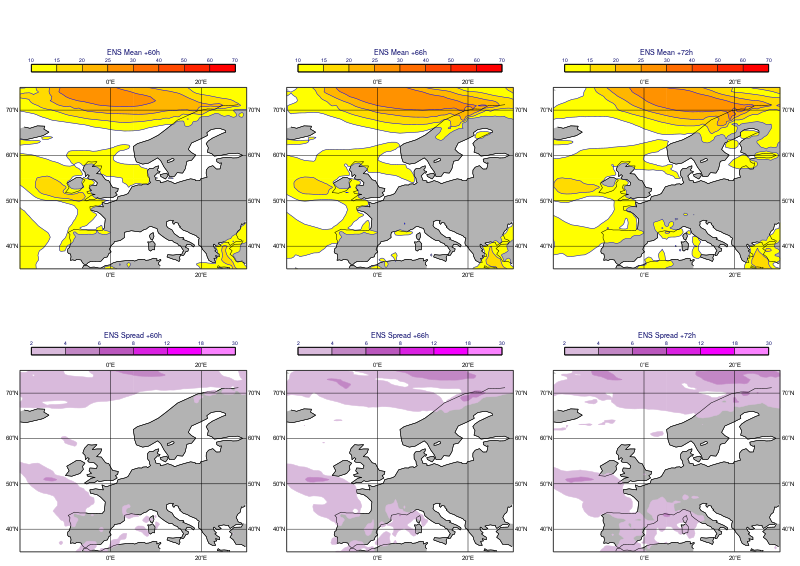

In [10]:
mv.plot(dw[0], fs_mean[0], cont_mean, title_mean,
        dw[1], fs_mean[1], cont_mean, title_mean,
        dw[2], fs_mean[2], cont_mean, title_mean,
        dw[3], fs_spread[0], cont_spread, title_spread,
        dw[4], fs_spread[1], cont_spread, title_spread,
        dw[5], fs_spread[2], cont_spread, title_spread)

# Additional resources

- [Introductory Metview training course](https://confluence.ecmwf.int/display/METV/Data+analysis+and+visualisation+using+Metview)
- [Metview's Python interface](https://confluence.ecmwf.int/display/METV/Metview%27s+Python+Interface)
- [Function list](https://confluence.ecmwf.int/display/METV/List+of+Operators+and+Functions)